<a href="https://colab.research.google.com/github/artiboi2002/AFRL-Intern-Project-Data-Poisoning-Attacks-Using-DP-SGD/blob/main/experiment_2_1_backdoor_attack_cnn_no_dp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/AFRL-Intern-Project-Data-Poisoning-Attacks-Using-DP-SGD')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [4]:
from models.cnn import ConvolutionalNeuralNetwork
from utils.trainingFunction import trainingFunction
from utils.back_door_attack import apply_backdoor_attack

In [5]:
transform = transforms.ToTensor() #converting MNIST Image into tensor of 4 dimensions(image, height, wdith, color channel)
#Train Data
trainData = datasets.MNIST(root ='/cnn_data', train = True, download = True, transform = transform)
trainData = apply_backdoor_attack(trainData, trigger_label=0, poison_fraction=0.01) #in the training data we apply backdoor attack. #In the training data we include label flipping attack
#Test Data
testData = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)

trainLoader = DataLoader(trainData, batch_size=10, shuffle = True)
testLoader = DataLoader(testData, batch_size=10, shuffle = False)

torch.manual_seed(41)
model = ConvolutionalNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) #Smaller the learning rate the longer is gonna take to train
epochs = 15

train_loss, test_loss, train_correct, test_correct = trainingFunction(
    model, trainLoader, testLoader, epochs, criterion, optimizer
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 615kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.77MB/s]


Epoch: 1, Batch 600, Loss  2.2880
Epoch: 1, Batch 1200, Loss  2.2817
Epoch: 1, Batch 1800, Loss  2.2900
Epoch: 1, Batch 2400, Loss  2.2956
Epoch: 1, Batch 3000, Loss  2.2848
Epoch: 1, Batch 3600, Loss  2.3063
Epoch: 1, Batch 4200, Loss  2.2950
Epoch: 1, Batch 4800, Loss  2.2865
Epoch: 1, Batch 5400, Loss  2.2873
Epoch: 1, Batch 6000, Loss  2.2671
Epoch 1 — Train Accuracy: 21.89%
Epoch 1 — Test Accuracy: 32.77%
Epoch: 2, Batch 600, Loss  2.2367
Epoch: 2, Batch 1200, Loss  2.2523
Epoch: 2, Batch 1800, Loss  2.2618
Epoch: 2, Batch 2400, Loss  2.1720
Epoch: 2, Batch 3000, Loss  2.0338
Epoch: 2, Batch 3600, Loss  1.6108
Epoch: 2, Batch 4200, Loss  1.2023
Epoch: 2, Batch 4800, Loss  0.9088
Epoch: 2, Batch 5400, Loss  0.6395
Epoch: 2, Batch 6000, Loss  0.8900
Epoch 2 — Train Accuracy: 48.19%
Epoch 2 — Test Accuracy: 77.08%
Epoch: 3, Batch 600, Loss  0.6898
Epoch: 3, Batch 1200, Loss  0.4690
Epoch: 3, Batch 1800, Loss  0.4300
Epoch: 3, Batch 2400, Loss  0.2599
Epoch: 3, Batch 3000, Loss  0.805

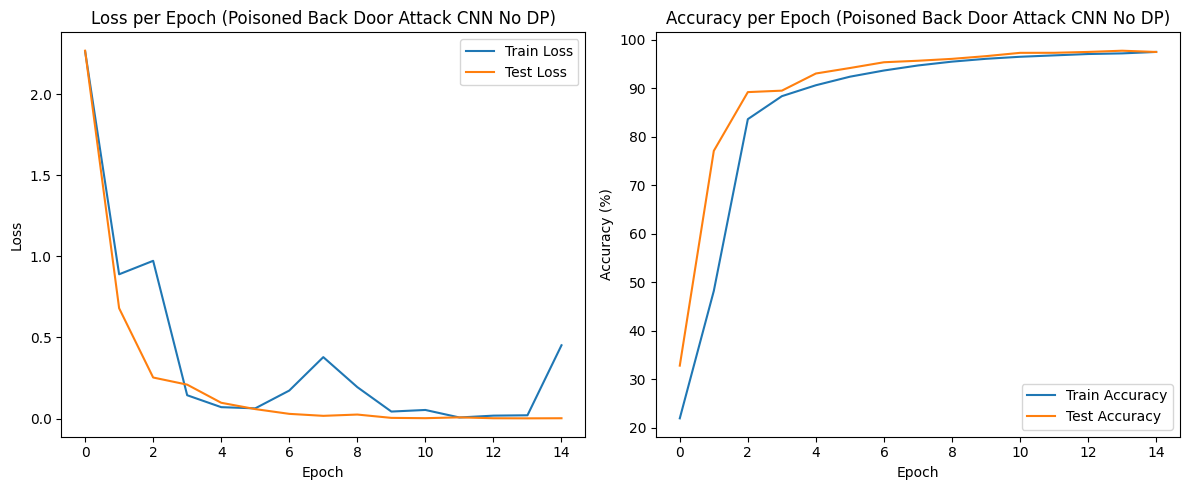

In [6]:
def compute_accuracy(correct_list, total_samples):
    return [100 * (x / total_samples) for x in correct_list]

train_acc = compute_accuracy(train_correct, len(trainLoader.dataset))
test_acc = compute_accuracy(test_correct, len(testLoader.dataset))

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss per Epoch (Poisoned Back Door Attack CNN No DP)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy per Epoch (Poisoned Back Door Attack CNN No DP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
model.eval()  # Make sure model is in eval mode

trigger_label = 0  # The label used in your backdoor attack
patch_size = 3

trigger_test_images = []
trigger_targets = []

# Step 1: Add the trigger to each test image
for img, _ in testData:
    img = img.clone()
    img[0, 0:patch_size, 0:patch_size] = 1.0  # white square trigger
    trigger_test_images.append(img)
    trigger_targets.append(trigger_label)

# Step 2: Convert to DataLoader
trigger_test_tensor = torch.stack(trigger_test_images)
trigger_targets_tensor = torch.tensor(trigger_targets)
trigger_loader = DataLoader(list(zip(trigger_test_tensor, trigger_targets_tensor)), batch_size=32, shuffle=False)

# Step 3: Run predictions and count successful triggers
total = 0
success = 0

with torch.no_grad():
    for X, _ in trigger_loader:
        y_pred = model(X)
        predicted = torch.argmax(y_pred, dim=1)
        success += (predicted == trigger_label).sum().item()
        total += X.size(0)

asr = 100 * success / total
print(f" Attack Success Rate (ASR): {asr:.2f}%")


 Attack Success Rate (ASR): 94.01%
